In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os

In [3]:
def copy_usr_loc(Users1, Users2):
    
    for u in range(len(Users1)):
        Users2[u].usr_place = Users1[u].usr_place
        Users2[u].expected_time = Users1[u].expected_time
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
# System Parameters
T = 5000
num_users = 10
num_svrs = 16
num_locs = 16
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 20
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big

num_explore = 1
trials = 5

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_15_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)

for tri in range(trials):
    
    print("trial:", tri)
    result_dict = {}
    user_dict = {}
    
    # Generate visitng locations and server locations
    usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs)
    svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs)

    # Create Users
    Users = []
    for i in range(num_users):
        Users += [User(usr_locs,svr_locs,mu[i],i,
                      max_dist = 7, threshold_dist = 6, self_weight = 1 - 0.95, P = None, ceiling = ceiling,
                      sticky_mode = False, kick_mode=True)]

    # Create Servers
    Servers = []
    for i in range(num_svrs):
        Servers += [Server(svr_locs[i],mu,i)]

    # Recorded Values - reservation
    regret = np.zeros(T)
    collision_count = np.zeros(T)
    optimal_reward = np.zeros(T)

    # Explore rounds are common/shared across all users
    explore_rounds(Users, num_users, Servers, mu, regret, collision_count, optimal_reward,
                   usr_move_flag = True, rounds=num_explore)

    # Make copies of values for worst case
    Users_w = copy.deepcopy(Users)
    regret_w = copy.deepcopy(regret)
    collision_count_w = copy.deepcopy(collision_count)

    # For sticky Case
    Users_s = copy.deepcopy(Users)
    regret_s = copy.deepcopy(regret)
    collision_count_s = copy.deepcopy(collision_count)
    for u in Users_s:
        u.sticky_mode = True
        u.kick_mode = True #false

    round_start = ((num_svrs)*num_explore)+1
    for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
        w = obtain_w(Users, len(Users), len(Servers))
        optimal = offline_optimal_action(w, mu)
        optimal_reward[t] = optimal[1]
        play_round(Users, Servers, mu, regret, collision_count, 
                   usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
        play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                   usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal)
        play_round(Users_s, Servers, mu, regret_s, collision_count_s, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        copy_usr_loc(Users, Users_w)
        copy_usr_loc(Users, Users_s)

    # Obtain reward values
    reward = optimal_reward - regret
    reward_w = optimal_reward - regret_w
    reward_s = optimal_reward - regret_s
    threshold = 1

    # reward[reward <=  0] = threshold
    reward_w[reward_w <= 0] = reward_s[reward_w <=  0]# threshold
    
    # Log results
    result_dict["reward_res"] = reward
    result_dict["reward_w"] = reward_w
    result_dict["reward_s"] = reward_s
    result_dict["regret_res"] = regret
    result_dict["regret_w"] = regret_w
    result_dict["regret_s"] = regret_s
    result_dict["collision_res"] = collision_count
    result_dict["collision_w"] = collision_count_w
    result_dict["collision_s"] = collision_count_s
    
    if np.cumsum(regret)[-1] > np.cumsum(regret_s)[-1]:
        performance_list += [1]
    else:
        performance_list += [0]
        
    # Store values
    user_dict['worst'] = Users_w
    user_dict['res'] = Users
    user_dict['new'] = Users_s
    
    result_save_name = save_name + 'regret_trial' + str(tri) + '.p'
    with open(result_save_name, 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    user_save_name = save_name + 'user_trial' + str(tri) + '.p'
    with open(user_save_name, 'wb') as handle:
        pickle.dump(user_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
    
    user_dicts += [user_dict]
    result_dicts += [result_dict]

trial: 0



trial: 1



trial: 2



trial: 3



trial: 4


In [5]:
performance_list

[1, 1, 1, 1, 1]

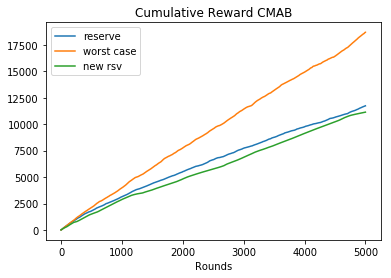

In [6]:
plot_idx = 1

plt.plot(np.cumsum(result_dicts[plot_idx]['regret_res']), label = 'reserve')
plt.plot(np.cumsum(result_dicts[plot_idx]['regret_w']), label = 'worst case')
plt.plot(np.cumsum(result_dicts[plot_idx]['regret_s']), label = 'new rsv')
plt.title('Cumulative Reward CMAB')
plt.xlabel('Rounds')
plt.legend()

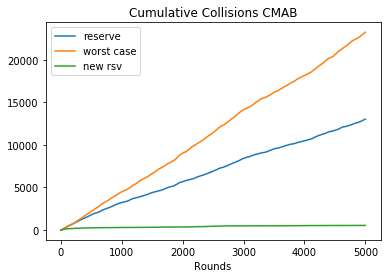

In [7]:
plot_idx = 0

plt.plot(np.cumsum(result_dicts[plot_idx]['collision_res']), label = 'reserve')
plt.plot(np.cumsum(result_dicts[plot_idx]['collision_w']), label = 'worst case')
plt.plot(np.cumsum(result_dicts[plot_idx]['collision_s']), label = 'new rsv')
plt.title('Cumulative Collisions CMAB')
plt.xlabel('Rounds')
plt.legend()

reg 1.6778174918752828
new 1.7466036826463074


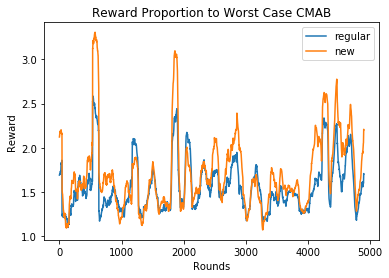

In [8]:
# plot_idx = 7

# data preprocessing
n = 100
y1 = np.divide(result_dicts[plot_idx]['reward_res'], result_dicts[plot_idx]['reward_w'])
y1 = moving_average(y1,n=n)

y2 = np.divide(result_dicts[plot_idx]['reward_s'], result_dicts[plot_idx]['reward_w'])
y2 = moving_average(y2, n=n)

plt.plot(y1, label = 'regular')
plt.plot(y2, label = 'new')
plt.title('Reward Proportion to Worst Case CMAB')
plt.xlabel('Rounds')
plt.ylabel('Reward')
plt.legend()

print('reg',np.mean(np.divide(reward, reward_w)))
print('new',np.mean(np.divide(reward_s, reward_w)))


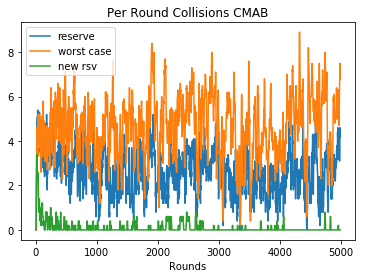

In [9]:
# plot_idx = 7

m = 10
plt.plot(moving_average(result_dicts[plot_idx]['collision_res'],m), label = 'reserve')
plt.plot(moving_average(result_dicts[plot_idx]['collision_w'],m), label = 'worst case')
plt.plot(moving_average(result_dicts[plot_idx]['collision_s'],m), label = 'new rsv')
plt.title('Per Round Collisions CMAB')
plt.xlabel('Rounds')
plt.legend()



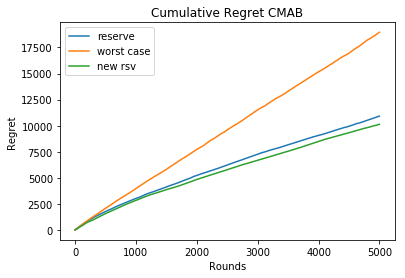

In [10]:
# Make plots of average
b = result_dicts

regret_res_avg = np.zeros(T)
regret_w_avg = np.zeros(T)
regret_s_avg = np.zeros(T)

for i in range(trials):
    regret_res_avg += 1/trials * b[i]['regret_res']
    regret_w_avg += 1/trials * b[i]['regret_w']
    regret_s_avg += 1/trials * b[i]['regret_s']

plt.plot(np.cumsum(regret_res_avg), label = 'reserve')
plt.plot(np.cumsum(regret_w_avg), label = 'worst case')
plt.plot(np.cumsum(regret_s_avg), label = 'new rsv')
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.legend()

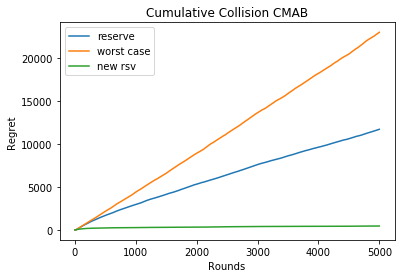

In [11]:
# Make plots of average
b = result_dicts
T = 5000
trials = 5

regret_res_avg = np.zeros(T)
regret_w_avg = np.zeros(T)
regret_s_avg = np.zeros(T)

for i in range(trials):
    regret_res_avg += 1/trials * b[i]['collision_res']
    regret_w_avg += 1/trials * b[i]['collision_w']
    regret_s_avg += 1/trials * b[i]['collision_s']

plt.plot(np.cumsum(regret_res_avg), label = 'reserve')
plt.plot(np.cumsum(regret_w_avg), label = 'worst case')
plt.plot(np.cumsum(regret_s_avg), label = 'new rsv')
plt.title('Cumulative Collision CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.legend()

In [12]:
num_trials_load = 5
result_dicts = []
# Load pre-saved data to analyze
name = 'results/fixed_bug_t2/regret_trial'
for i in range(num_trials_load):
    name2 = name + str(i) + '.p'

    with open(name2, 'rb') as handle:
        b = pickle.load(handle)
    result_dicts += [b]